In [3]:
from Utils import *
import pandas as pd
import numpy as np
import re

#for getting the fisher exact test
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

cohort_root = 'example_patients.csv'

#### First We can load in the example patient dataset into a preprocessed data structure

In [4]:
sd = LNDataset(cohort_root)

#### The Raw input data looks like this
We're storing information on gender and ID For housekeeping purposes
Tm Laterality is telling use which side of the head the main tumor is one (Left, Right, Bilateral)

Affected Lymph Node UPPER is the input where care about.  This gives us a string of the regions in the head with lymph nodes affected by cancer.  E.G. L2, L3 correspond to a patient with nodes in the left side of their head.
Since we only write L2 here, we asusme that 2A, 2B, and 3 are all affected in this patients left side of the head

These remaining values are all used to measure toxicity during a 6 month post-treatment follow up for the patients.

 * Neck Boost: The patient recieved extra radiation to their neck
 * Feeding tube: If a patient needed a feeding tube inserted/Swallowing issues
 * Aspiration: If a patient needed a procedure to remove fluid from their lungs/Breathing issues
 
Aspiration rate pre vs post therapy and overall is usually related, but in this example, we're simply looking at Aspriation rate overall

In [6]:
sd.data.drop('nodes',axis=1).head()

,Gender,Tm Laterality (R/L),Affected Lymph node UPPER,Neck boost (Y/N),Feeding tube 6m,Aspiration rate Pre-therapy,Aspiration rate Post-therapy,Aspiration rate(Y/N)
id,,,,,,,,
1,Male,R,"L1B, L2, L3, R2, R3",N,N,N,Y,N
2,Male,R,"L2, L3",Y,Y,N,N,N
3,Male,R,"L2,R2",Y,N,N,Y,N
4,Female,L,"R2, R3, L2, L3",Y,N,N,Y,N
5,Male,R,"R1B, R2, R3, R4, L2",Y,N,Y,N,Y


For our graph representation, we can one-hot encode the affected nodes for each patient. 
First we consider both the left and right side of the head.

In [7]:
sd.monograms.head()

,L1A,L1B,L2A,L2B,L3,L4,L5A,L5B,L6,LRPLN,R1A,R1B,R2A,R2B,R3,R4,R5A,R5B,R6,RRPLN
id,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


We can also merge them together to get a dual-graph representation, which we use as the values for our 'nonspatial' baseline representation of the users

In [8]:
sd.dual_monograms.head()

,1A,1B,2A,2B,3,4,5A,5B,6,RPLN
id,,,,,,,,,,
1,0.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0


These nodes are connected, so they form a graph.  We can show this as an adjancency matrix

In [15]:
sd.adjacency

,1A,1B,2A,2B,3,4,5A,5B,6,RPLN
1A,1,1,0,0,0,0,0,0,1,0
1B,1,1,1,0,1,0,0,0,0,0
2A,0,1,1,1,1,0,0,0,0,0
2B,0,0,1,1,0,0,1,0,0,0
3,0,1,1,0,1,1,1,0,1,0
4,0,0,0,0,1,1,0,1,1,0
5B,0,0,0,1,1,0,1,1,0,0
5B,0,0,0,0,0,1,1,1,0,0
6,1,0,0,0,1,1,0,0,1,0
RPLN,0,0,0,0,0,0,0,0,0,1


we can also enumerate all valid node combinations that form an edge

In [16]:
' '.join(sd.get_bigram_names()[0])

'1A1B 1A6 1B2A 1B3 2A2B 2A3 2B5A 34 35A 36 45B 46 5A5B'

Extracting these edges (where an edge is affected if both node are) can be done in the same way as before

In [21]:
sd.dual_bigrams.head()

,1A1B,1A6,1B2A,1B3,2A2B,2A3,2B5A,34,35A,36,45B,46,5A5B
id,,,,,,,,,,,,,
1,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


The combination of these form our complete dual graph representation that we do clustering on

In [24]:
sd.spatial().head()

,1A1B,1A6,1B2A,1B3,2A2B,2A3,2B5A,34,35A,36,...,1A,1B,2A,2B,3,4,5A,5B,6,RPLN
id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0


We can do clustering on these groups.  Here were testing for k = 6, as well as getting clusters of patients that are all almost identical

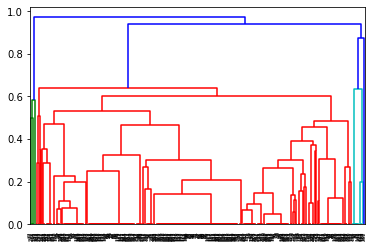

In [26]:
patterns, clusters, leaves = get_clustering(sd.spatial().values)

In [29]:
print(len(np.unique(patterns)), 'unique patterns')

33 unique patterns


#### Todo - Make some stuff that automatically explains the correlations of our results